In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import rasterio.plot
import numpy as np
from skimage.transform import resize
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import DepthwiseConv2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [18]:
import time

start_time = time.time()

In [19]:
pre_pseu_iso = pd.read_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Crop Suitability Modeling/Data/saved_csv/pre_pseu_iso_str.csv')

In [20]:
pre_pseu_iso

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,-121.730795,41.829775,91.0,119,35,7289.0,292.0,-43.0,335.0,10.0,...,0.0,350.0,49.0,7.0,45.0,143.0,30.0,30.0,136.0,1
1,-122.345282,41.689828,113.0,121,36,7102.0,309.0,-21.0,330.0,30.0,...,23.0,538.0,88.0,9.0,61.0,256.0,34.0,34.0,254.0,1
2,-120.429168,41.572345,95.0,116,33,7895.0,302.0,-48.0,350.0,6.0,...,-4.0,399.0,56.0,7.0,48.0,163.0,28.0,28.0,162.0,1
3,-121.114908,41.130171,103.0,120,34,7682.0,307.0,-40.0,347.0,5.0,...,5.0,413.0,62.0,5.0,55.0,185.0,20.0,20.0,185.0,1
4,-121.045248,41.139732,102.0,120,34,7698.0,307.0,-41.0,348.0,5.0,...,5.0,388.0,55.0,5.0,51.0,164.0,21.0,21.0,164.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,-117.440188,36.404934,211.0,117,31,8747.0,410.0,41.0,368.0,109.0,...,95.0,85.0,13.0,2.0,53.0,40.0,8.0,19.0,34.0,0
1214,-124.310930,40.241995,122.0,49,39,2665.0,194.0,68.0,125.0,90.0,...,90.0,2116.0,409.0,3.0,87.0,1203.0,19.0,36.0,1203.0,0
1215,-117.122139,36.037518,120.0,120,34,7990.0,310.0,-40.0,350.0,27.0,...,14.0,137.0,24.0,2.0,61.0,70.0,10.0,31.0,55.0,0
1216,-117.813230,35.433641,153.0,126,36,7549.0,342.0,0.0,342.0,65.0,...,55.0,142.0,28.0,1.0,75.0,82.0,4.0,16.0,68.0,0


In [21]:
def train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test):
    # Training the model
    model.fit(X_train, y_train)
    
    # Prediction on validation set
    y_pred_val = model.predict(X_val)
    y_pred_proba_val = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else None

    # Prediction on test set
    y_pred_test = model.predict(X_test)
    y_pred_proba_test = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Evaluation on Validation Set
    metrics_val = {
        'accuracy_val': accuracy_score(y_val, y_pred_val),
        'precision_val': precision_score(y_val, y_pred_val),
        'recall_val': recall_score(y_val, y_pred_val),
        'f1score_val': f1_score(y_val, y_pred_val),
        'auc_val': roc_auc_score(y_val, y_pred_proba_val) if y_pred_proba_val is not None else None,
        'probabilities_val': y_pred_proba_val
    }

    # Evaluation on Test Set
    metrics_test = {
        'accuracy_test': accuracy_score(y_test, y_pred_test),
        'precision_test': precision_score(y_test, y_pred_test),
        'recall_test': recall_score(y_test, y_pred_test),
        'f1score_test': f1_score(y_test, y_pred_test),
        'auc_test': roc_auc_score(y_test, y_pred_proba_test) if y_pred_proba_test is not None else None,
        'probabilities_test': y_pred_proba_test
    }

    return model.__class__.__name__, metrics_val, metrics_test


# Traditional Model Iteration

In [22]:
# Defined the base learners
base_learners = [
    ('dt', DecisionTreeClassifier(max_depth=3)),
    ('svm', SVC(probability=True))
]

# Defined the meta-learner
meta_learner = LogisticRegression()

traditional_models = [
    StackingClassifier(estimators=base_learners, final_estimator=meta_learner),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42),
    xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False),
    RandomForestClassifier(n_estimators=100, random_state=42),
]


In [23]:
# Data Preparation
X = pre_pseu_iso.iloc[:, 2:21].values  # feature columns
y = pre_pseu_iso['presence'].values  # target column

# Splitting data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # Splitting into 70% training and 30% temporary
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Splitting temporary into 50% validation and 50% test

# Data normalization - fited the scaler only on the training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [24]:
from joblib import Parallel, delayed

# Add verbose and error capturing
traditional_results = Parallel(n_jobs=-1, verbose=11, backend="threading")(
    delayed(train_and_evaluate)(model, X_train, y_train, X_val, y_val, X_test, y_test) for model in traditional_models
)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished


In [25]:
# Initialized an empty DataFrame for summarized results
summary_df_traditional = pd.DataFrame(columns=[
    'Model Name',
    'Validation Accuracy', 'Validation Precision', 'Validation Recall', 'Validation F1 Score', 'Validation AUC', 'Validation Probabilities',
    'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1 Score', 'Test AUC', 'Test Probabilities'
])

for result in traditional_results:
    model_name, metrics_val, metrics_test = result
    new_row = {
        'Model Name': model_name,
        'Validation Accuracy': metrics_val['accuracy_val'],
        'Validation Precision': metrics_val['precision_val'],
        'Validation Recall': metrics_val['recall_val'],
        'Validation F1 Score': metrics_val['f1score_val'],
        'Validation AUC': metrics_val['auc_val'],
        'Validation Probabilities': metrics_val['probabilities_val'],
        'Test Accuracy': metrics_test['accuracy_test'],
        'Test Precision': metrics_test['precision_test'],
        'Test Recall': metrics_test['recall_test'],
        'Test F1 Score': metrics_test['f1score_test'],
        'Test AUC': metrics_test['auc_test'],
        'Test Probabilities': metrics_test['probabilities_test']
    }
    # Appended new row to the summary DataFrame 
    summary_df_traditional = pd.concat([summary_df_traditional, pd.DataFrame([new_row])], ignore_index=True)


In [26]:
summary_df_traditional

,Model Name,Validation Accuracy,Validation Precision,Validation Recall,Validation F1 Score,Validation AUC,Validation Probabilities,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test AUC,Test Probabilities
0,StackingClassifier,0.961749,0.942529,0.976190,0.959064,0.975349,"[0.04450410781714732, 0.031151746449597752, 0....",0.945355,0.963855,0.919540,0.941176,0.967074,"[0.035184613163516724, 0.02868552657777399, 0...."
1,GradientBoostingClassifier,0.956284,0.922222,0.988095,0.954023,0.963684,"[0.018740280760850915, 0.01830567396225306, 0....",0.934426,0.941176,0.919540,0.930233,0.946420,"[0.01830567396225306, 0.02788020829274152, 0.9..."
2,XGBClassifier,0.967213,0.943182,0.988095,0.965116,0.990741,"[0.010596287, 0.0017872627, 0.99423933, 0.0163...",0.928962,0.962500,0.885057,0.922156,0.982519,"[0.0024642786, 0.0009824767, 0.99076384, 0.533..."
3,RandomForestClassifier,0.967213,0.943182,0.988095,0.965116,0.987374,"[0.05, 0.0, 0.99, 0.03, 0.0, 1.0, 0.06, 0.0, 0...",0.950820,0.987500,0.908046,0.946108,0.981741,"[0.0, 0.0, 0.99, 0.5, 0.95, 0.03, 0.05, 0.08, ..."


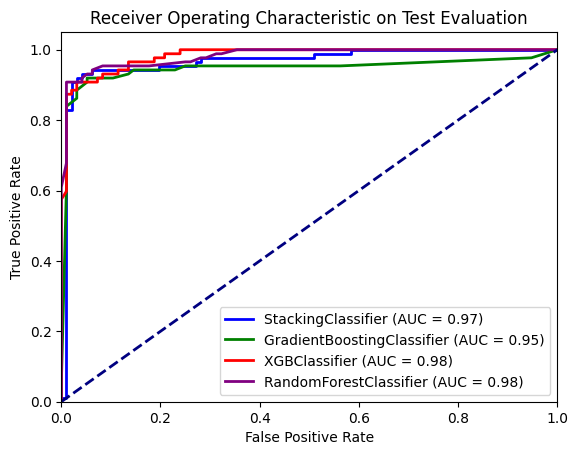

In [27]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

y_true = np.array(y_test)

models = summary_df_traditional['Model Name'].values
colors = ['blue', 'green', 'red', 'purple']  

plt.figure()

for i, model_name in enumerate(models):
    model_probs = summary_df_traditional.loc[summary_df_traditional['Model Name'] == model_name, 'Test Probabilities'].values[0]
    if isinstance(model_probs, str):
        # Converted string representation to actual list
        model_probs = np.fromstring(model_probs.strip("[]"), sep=',')

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, model_probs)
    roc_auc = auc(fpr, tpr)

    # Plotting
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic on Test Evaluation')
plt.legend(loc="lower right")
plt.show()

# Neural Networks 

In [28]:
# Build the model
model_ks = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_ks.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2024-01-10 15:49:36.072067: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-10 15:49:36.072133: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-10 15:49:36.072256: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-10 15:49:36.072326: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-10 15:49:36.072734: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [29]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation, Dropout

model_enhanced_mlp = Sequential()
model_enhanced_mlp.add(Dense(128, input_shape=(X_train.shape[1],)))
model_enhanced_mlp.add(BatchNormalization())
model_enhanced_mlp.add(Activation('relu'))
model_enhanced_mlp.add(Dropout(0.5))
model_enhanced_mlp.add(Dense(64))
model_enhanced_mlp.add(BatchNormalization())
model_enhanced_mlp.add(Activation('relu'))
model_enhanced_mlp.add(Dropout(0.5))
model_enhanced_mlp.add(Dense(1, activation='sigmoid'))

model_enhanced_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [30]:
from keras.models import Model
from keras.layers import Input, Dense

# Define encoder
input_data = Input(shape=(X_train.shape[1],))
encoded = Dense(64, activation='relu')(input_data)
encoded = Dense(32, activation='relu')(encoded)

# Define decoder
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(X_train.shape[1], activation='sigmoid')(decoded)

# Autoencoder
autoencoder = Model(input_data, decoded)

# Encoder - for dimensionality reduction
encoder = Model(input_data, encoded)

# Compiled autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

encoded_input = Input(shape=(X_train.shape[1],))
classifier_layer = Dense(1, activation='sigmoid')(encoded_input)
classifier = Model(encoded_input, classifier_layer)

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [31]:
neural_network_models = [
    (model_ks, "Keras Sequential"),
    (model_enhanced_mlp, "Multi Perceptron"),
    (classifier, 'Autoencoder'),
]

In [32]:
# Data Preparation
X = pre_pseu_iso.iloc[:, 2:21].values  # feature columns
y = pre_pseu_iso['presence'].values  # target column

# Splitting data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # Splitting into 70% training and 30% temporary
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Splitting temporary into 50% validation and 50% test

# Data normalization - fited the scaler only on the training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [33]:
def train_and_evaluate(model, model_name, X_train, y_train, X_val, y_val, X_test, y_test):
    # Compiled the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Trained the model using training and validation sets
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))
    
    # Evaluated the model on the test data
    test_loss, test_acc = model.evaluate(X_test, y_test)
    
    # Prediction on validation set
    y_pred_proba_val = model.predict(X_val).ravel()
    y_pred_val = (y_pred_proba_val >= 0.5).astype(int)
    # Prediction on test set
    y_pred_proba_test = model.predict(X_test).ravel()
    y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

    # Evaluation on Validation Set
    metrics_val = {
        'accuracy_val': accuracy_score(y_val, y_pred_val),
        'precision_val': precision_score(y_val, y_pred_val),
        'recall_val': recall_score(y_val, y_pred_val),
        'f1score_val': f1_score(y_val, y_pred_val),
        'auc_val': roc_auc_score(y_val, y_pred_proba_val) if y_pred_proba_val is not None else None,
        'probabilities_val': y_pred_proba_val
    }

    # Evaluation on Test Set
    metrics_test = {
        'accuracy_test': accuracy_score(y_test, y_pred_test),
        'precision_test': precision_score(y_test, y_pred_test),
        'recall_test': recall_score(y_test, y_pred_test),
        'f1score_test': f1_score(y_test, y_pred_test),
        'auc_test': roc_auc_score(y_test, y_pred_proba_test) if y_pred_proba_test is not None else None,
        'probabilities_test': y_pred_proba_test
    }

    return model_name, metrics_val, metrics_test


In [34]:
neural_network_results = Parallel(n_jobs=-1, verbose=11, backend="threading")(
    delayed(train_and_evaluate)(model, name, X_train, y_train, X_val, y_val, X_test, y_test) for model, name in neural_network_models
)

Epoch 1/20
Epoch 1/20
Epoch 1/20


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
2024-01-10 15:49:36.843020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 2s 49ms/step - loss: 0.7016 - accuracy: 0.6279 - val_loss: 0.6423 - val_accuracy: 0.7049
Epoch 2/20
27/27 [==============================] - 2s 51ms/step - loss: 0.5510 - accuracy: 0.7465 - val_loss: 0.3798 - val_accuracy: 0.8470
Epoch 2/20
27/27 [==============================] - 1s 32ms/step - loss: 0.6321 - accuracy: 0.6984 - val_loss: 0.5922 - val_accuracy: 0.7541
Epoch 3/20
27/27 [==============================] - 1s 39ms/step - loss: 0.3354 - accuracy: 0.8838 - val_loss: 0.3231 - val_accuracy: 0.9016
Epoch 3/20
27/27 [==============================] - 1s 19ms/step - loss: 0.5757 - accuracy: 0.7535 - val_loss: 0.5524 - val_accuracy: 0.7923
Epoch 4/20
27/27 [==============================] - 0s 17ms/step - loss: 0.5314 - accuracy: 0.7899 - val_loss: 0.5202 - val_accuracy: 0.8087
Epoch 5/20
27/27 [==============================] - 1s 23ms/step - loss: 0.3037 - accuracy: 0.8932 - val_loss: 0.3045 - val_accuracy: 0.9126
Epoch 4/20
27/27 [======

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.6s


27/27 [==============================] - 0s 15ms/step - loss: 0.2584 - accuracy: 0.9143 - val_loss: 0.4738 - val_accuracy: 0.8907
Epoch 17/20
27/27 [==============================] - 0s 14ms/step - loss: 0.2345 - accuracy: 0.9178 - val_loss: 0.3222 - val_accuracy: 0.9126
Epoch 18/20
27/27 [==============================] - 1s 23ms/step - loss: 0.1685 - accuracy: 0.9366 - val_loss: 0.2238 - val_accuracy: 0.9344
Epoch 11/20
27/27 [==============================] - 0s 14ms/step - loss: 0.3160 - accuracy: 0.9061 - val_loss: 0.7712 - val_accuracy: 0.7705
Epoch 19/20
27/27 [==============================] - 1s 23ms/step - loss: 0.1866 - accuracy: 0.9390 - val_loss: 0.2187 - val_accuracy: 0.9399
Epoch 12/20
27/27 [==============================] - 1s 23ms/step - loss: 0.1701 - accuracy: 0.9425 - val_loss: 0.2205 - val_accuracy: 0.9344
Epoch 13/20
27/27 [==============================] - 0s 13ms/step - loss: 0.1692 - accuracy: 0.9390 - val_loss: 0.2149 - val_accuracy: 0.9399
Epoch 14/20
27/27 

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.3s finished


In [35]:
# Initialized an empty DataFrame for summarized results
summary_df_nn = pd.DataFrame(columns=[
    'Model Name',
    'Validation Accuracy', 'Validation Precision', 'Validation Recall', 'Validation F1 Score', 'Validation AUC', 'Validation Probabilities',
    'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1 Score', 'Test AUC', 'Test Probabilities'
])

for result in neural_network_results:
    model_name, metrics_val, metrics_test = result
    new_row = {
        'Model Name': model_name,
        'Validation Accuracy': metrics_val['accuracy_val'],
        'Validation Precision': metrics_val['precision_val'],
        'Validation Recall': metrics_val['recall_val'],
        'Validation F1 Score': metrics_val['f1score_val'],
        'Validation AUC': metrics_val['auc_val'],
        'Validation Probabilities': metrics_val['probabilities_val'],
        'Test Accuracy': metrics_test['accuracy_test'],
        'Test Precision': metrics_test['precision_test'],
        'Test Recall': metrics_test['recall_test'],
        'Test F1 Score': metrics_test['f1score_test'],
        'Test AUC': metrics_test['auc_test'],
        'Test Probabilities': metrics_test['probabilities_test']
    }
    # Appended new row to the summary DataFrame
    summary_df_nn = pd.concat([summary_df_nn, pd.DataFrame([new_row])], ignore_index=True)


In [36]:
summary_df_nn['Model Name'].values

array(['Keras Sequential', 'Multi Perceptron', 'Autoencoder'],
      dtype=object)

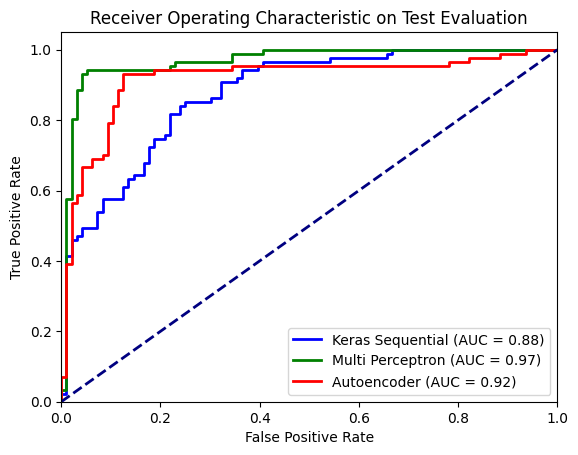

In [37]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

y_true = np.array(y_test)

models = summary_df_nn['Model Name'].values
colors = ['blue', 'green', 'red']  

plt.figure()

for i, model_name in enumerate(models):
    model_probs = summary_df_nn.loc[summary_df_nn['Model Name'] == model_name, 'Test Probabilities'].values[0]
    if isinstance(model_probs, str):
        # Convert string representation to actual list
        model_probs = np.fromstring(model_probs.strip("[]"), sep=',')

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, model_probs)
    roc_auc = auc(fpr, tpr)

    # Plotting
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic on Test Evaluation')
plt.legend(loc="lower right")
plt.show()


# CNN Model Iteration

In [38]:
# Loaded bioclimatic variables data
bioclim_data = []
for i in range(1, 20):
    file_name = "/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Crop Suitability Modeling/Data/bioclims/californiaclipped/bio_" + str(i) + ".tif"
    with rasterio.open(file_name) as src:
        data = src.read(1).astype(np.float32)
        # Masked out nodata values
        data = np.ma.masked_equal(data, src.nodata)
        bioclim_data.append(data)

bioclim_data = np.stack(bioclim_data, axis=2)

In [39]:
def extract_windowed_data(presence_points, bioclim_data, window_size=8):
    """
    Extracts windowed bioclimatic variable data around crop presence points.
    
    Parameters:
    -----------
    presence_points : pandas.DataFrame
        A pandas dataframe containing crop presence points with 'Longitude', 'Latitude', 
        and 'presence' columns.
    bioclim_data : numpy.ndarray
        A numpy array containing bioclimatic variable data.
    window_size : int, optional
        The size of the window around the crop presence point to extract. Default is 32.
        
    Returns:
    --------
    tuple
        A tuple containing two numpy arrays. The first array contains the extracted windowed
        bioclimatic variable data, and the second array contains the corresponding crop presence
        labels.
    """
    x = []
    y = []
    window_size=int(window_size/2)

    for _, row in presence_points.iterrows():
        # Convert latitude and longitude to pixel coordinates
        lon, lat = row['Longitude'], row['Latitude']
        x_coord, y_coord = src.index(lon, lat)
        #x_coord, y_coord = int(x_coord), int(y_coord)


        # Check if window is large enough
        if x_coord >= window_size and x_coord < src.width - window_size and \
           y_coord >= window_size and y_coord < src.height - window_size:
            # Extract a window of size window_size X window_size around the crop presence point
            window = bioclim_data[y_coord-window_size:y_coord+window_size, x_coord-window_size:x_coord+window_size, :]

            # Append the window and patch area to lists
            x.append(window)
            y.append(row['presence'])

        else:
            print(f"Skipping crop presence point at ({lon}, {lat}) due to being too close to the edge.")

    # Convert to numpy arrays
    x = np.array(x)
    y = np.array(y)

    print(f"Number of crop presence points with large enough windows: {len(x)}")

    return x, y

In [40]:
x1,y1 = extract_windowed_data(pre_pseu_iso, bioclim_data)

Skipping crop presence point at (-123.48217418511496, 41.9802303850046) due to being too close to the edge.
Skipping crop presence point at (-114.96239787869736, 34.950105288412985) due to being too close to the edge.
Skipping crop presence point at (-114.6577569178699, 34.16754598187273) due to being too close to the edge.
Skipping crop presence point at (-120.03455148722702, 41.90360298920087) due to being too close to the edge.
Skipping crop presence point at (-114.85254115196037, 33.94810688028234) due to being too close to the edge.
Skipping crop presence point at (-123.83582019446062, 41.842935028937376) due to being too close to the edge.
Skipping crop presence point at (-114.60554059458376, 34.8461824731934) due to being too close to the edge.
Skipping crop presence point at (-121.54670634218638, 41.88216728750984) due to being too close to the edge.
Skipping crop presence point at (-122.7832453535165, 41.93944753823173) due to being too close to the edge.
Skipping crop presenc

In [41]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
model = Sequential()
model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 19)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lenet = model

In [42]:
model = Sequential()

# Block 1
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 19), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Classification block
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model_vgg = model

In [43]:
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model
from keras.initializers import glorot_uniform

def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters
    X_shortcut = X

    # First component of main path
    X = Conv2D(F1, (1, 1), strides=(1, 1), padding='same', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides=(1, 1), padding='same', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Shortcut path
    X_shortcut = Conv2D(F3, (1, 1), strides=(1, 1), padding='same', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


def ResNet50(input_shape=(32, 32, 19)):
    # Define the input
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='a')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc' + str(1), kernel_initializer=glorot_uniform(seed=0))(X)

    # Create Final model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

model_resnet50 = ResNet50(input_shape=(32, 32, 19))
model_resnet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [44]:
from keras.layers import concatenate

def inception_block(X, filters):
    # 1x1 conv
    conv1 = Conv2D(filters=filters, kernel_size=(1, 1), padding='same', activation='relu')(X)

    # 3x3 conv
    conv3 = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(X)

    # 5x5 conv
    conv5 = Conv2D(filters=filters, kernel_size=(5, 5), padding='same', activation='relu')(X)

    # 3x3 max pooling
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(X)

    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)

    return layer_out

def InceptionNet(input_shape):
    X_input = Input(input_shape)
    
    # Inception blocks
    X = inception_block(X_input, 32)
    X = inception_block(X, 64)
    X = MaxPooling2D(pool_size=(4, 4))(X)
    
    # Flatten and fully connected layer
    X = Flatten()(X)
    X = Dense(120, activation='relu')(X)
    X = Dense(84, activation='relu')(X)
    X = Dense(1, activation='sigmoid')(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='InceptionNet')
    
    return model

model_inception = InceptionNet(input_shape=(32, 32, 19))
model_inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [45]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_alexnet = Sequential()

# Assuming input_shape is (32, 32, 19) based on your dataset
input_shape = (32, 32, 19)

# Block 1
model_alexnet.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape, padding='same'))
model_alexnet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Block 2
model_alexnet.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu', padding='same'))
model_alexnet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Block 3
model_alexnet.add(Conv2D(filters=384, kernel_size=(3, 3), activation='relu', padding='same'))
model_alexnet.add(Conv2D(filters=384, kernel_size=(3, 3), activation='relu', padding='same'))
model_alexnet.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))

# Classification block
model_alexnet.add(Flatten())
model_alexnet.add(Dense(4096, activation='relu'))
model_alexnet.add(Dropout(0.5))
model_alexnet.add(Dense(4096, activation='relu'))
model_alexnet.add(Dropout(0.5))
model_alexnet.add(Dense(1, activation='sigmoid'))

model_alexnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
from keras.models import Sequential
from keras.layers import DepthwiseConv2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_mobilenet = Sequential()

# Depthwise Separable Convolution Block 1
model_mobilenet.add(DepthwiseConv2D(kernel_size=(3, 3), input_shape=(32, 32, 19), activation='relu', padding='same'))
model_mobilenet.add(Conv2D(64, (1, 1), activation='relu', padding='same'))
model_mobilenet.add(MaxPooling2D(pool_size=(2, 2)))

# Depthwise Separable Convolution Block 2
model_mobilenet.add(DepthwiseConv2D(kernel_size=(3, 3), activation='relu', padding='same'))
model_mobilenet.add(Conv2D(128, (1, 1), activation='relu', padding='same'))
model_mobilenet.add(MaxPooling2D(pool_size=(2, 2)))

# Depthwise Separable Convolution Block 3
model_mobilenet.add(DepthwiseConv2D(kernel_size=(3, 3), activation='relu', padding='same'))
model_mobilenet.add(Conv2D(128, (1, 1), activation='relu', padding='same'))
model_mobilenet.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the network before the fully connected layers
model_mobilenet.add(Flatten())

# Fully Connected Layers
model_mobilenet.add(Dense(1024, activation='relu'))
model_mobilenet.add(Dropout(0.5))
model_mobilenet.add(Dense(1024, activation='relu'))
model_mobilenet.add(Dropout(0.5))

# Output Layer
model_mobilenet.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mobilenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

custom_cnn_model = Sequential()

# First Convolutional Block with Batch Normalization
custom_cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 19)))
custom_cnn_model.add(BatchNormalization())
custom_cnn_model.add(MaxPooling2D((2, 2)))
custom_cnn_model.add(Dropout(0.2))

# Second Convolutional Block
custom_cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
custom_cnn_model.add(BatchNormalization())
custom_cnn_model.add(MaxPooling2D((2, 2)))
custom_cnn_model.add(Dropout(0.3))

# Third Convolutional Block
custom_cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
custom_cnn_model.add(BatchNormalization())
custom_cnn_model.add(MaxPooling2D((2, 2)))
custom_cnn_model.add(Dropout(0.4))

# Flatten and Dense Layers
custom_cnn_model.add(Flatten())
custom_cnn_model.add(Dense(128, activation='relu'))
custom_cnn_model.add(BatchNormalization())
custom_cnn_model.add(Dropout(0.5))
custom_cnn_model.add(Dense(1, activation='sigmoid'))  # For binary classification

custom_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
# neural_network_results=[]
# for model, name in neural_network_models:
#     result = train_and_evaluate(model, name, X_train, y_train, X_val, y_val, X_test, y_test)
#     neural_network_results.append(result)

In [49]:
# model = neural_network_models[0]  
# neural_network_results= train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test)

In [50]:
cnn_models = [
    (model_lenet, "LeNet"),
    (model_resnet50, "ResNet50"),
    (model_vgg, 'VGG'),
    (model_inception, 'Inception'),
    (model_alexnet, 'AlexNet'),
    (model_mobilenet, 'MobileNet'),
    (custom_cnn_model, 'Custom CNN')
]

In [51]:
def train_and_evaluate(model, model_name, X_train, y_train, X_val, y_val, X_test, y_test):
    # Compileed the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Trained the model using training and validation sets
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))
    
    # Evaluated the model on the test data
    test_loss, test_acc = model.evaluate(X_test, y_test)
    # Prediction on validation set
    y_pred_proba_val = model.predict(X_val).ravel()
    y_pred_val = (y_pred_proba_val >= 0.5).astype(int)
    # Prediction on test set
    y_pred_proba_test = model.predict(X_test).ravel()
    y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

    # Evaluation on Validation Set
    metrics_val = {
        'accuracy_val': accuracy_score(y_val, y_pred_val),
        'precision_val': precision_score(y_val, y_pred_val),
        'recall_val': recall_score(y_val, y_pred_val),
        'f1score_val': f1_score(y_val, y_pred_val),
        'auc_val': roc_auc_score(y_val, y_pred_proba_val) if y_pred_proba_val is not None else None,
        'probabilities_val': y_pred_proba_val
    }

    # Evaluation on Test Set
    metrics_test = {
        'accuracy_test': accuracy_score(y_test, y_pred_test),
        'precision_test': precision_score(y_test, y_pred_test),
        'recall_test': recall_score(y_test, y_pred_test),
        'f1score_test': f1_score(y_test, y_pred_test),
        'auc_test': roc_auc_score(y_test, y_pred_proba_test) if y_pred_proba_test is not None else None,
        'probabilities_test': y_pred_proba_test
    }

    return model_name, metrics_val, metrics_test


In [52]:
# Split data into training and other sets first
X = x1
y = y1

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalized the training set. Fit the scaler on X_train only
scaler = StandardScaler()
X_train_reshaped = X_train.reshape(-1, 19)  # Reshape to 2D array for scaling
scaler.fit(X_train_reshaped)  # Fit on the training data only

# Transformed the training data
X_train_scaled = scaler.transform(X_train_reshaped)
X_train_scaled = X_train_scaled.reshape(X_train.shape)

# Transformed the validation and test sets based on the scaler fitted on the training data
X_val_reshaped = X_val.reshape(-1, 19)
X_val_scaled = scaler.transform(X_val_reshaped)
X_val_scaled = X_val_scaled.reshape(X_val.shape)

X_test_reshaped = X_test.reshape(-1, 19)
X_test_scaled = scaler.transform(X_test_reshaped)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

# Resized the images after scaling, if needed
X_train_resized = resize(X_train_scaled, (X_train_scaled.shape[0], 32, 32, 19))
X_val_resized = resize(X_val_scaled, (X_val_scaled.shape[0], 32, 32, 19))
X_test_resized = resize(X_test_scaled, (X_test_scaled.shape[0], 32, 32, 19))

print(X_train_resized.shape, X_val_resized.shape, X_test_resized.shape)
print(y_train.shape, y_val.shape, y_test.shape)


(805, 32, 32, 19) (172, 32, 32, 19) (173, 32, 32, 19)
(805,) (172,) (173,)


In [53]:
X_train = X_train_resized
X_val = X_val_resized
X_test = X_test_resized

In [54]:

cnn_results = Parallel(n_jobs=-1, verbose=11, backend="threading")(
    delayed(train_and_evaluate)(model, name, X_train, y_train, X_val, y_val, X_test, y_test) for model, name in cnn_models
)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
26/26 [==============================] - 9s 304ms/step - loss: 0.7168 - accuracy: 0.6360 - val_loss: 0.7096 - val_accuracy: 0.5174
Epoch 2/20
26/26 [==============================] - 12s 344ms/step - loss: 0.9373 - accuracy: 0.5478 - val_loss: 0.6575 - val_accuracy: 0.6628
Epoch 2/20
26/26 [==============================] - 12s 350ms/step - loss: 6.2170 - accuracy: 0.6199 - val_loss: 2.3967 - val_accuracy: 0.5116
Epoch 2/20
26/26 [==============================] - 13s 370ms/step - loss: 0.6902 - accuracy: 0.5255 - val_loss: 0.6597 - val_accuracy: 0.6628
Epoch 2/20
26/26 [==============================] - 16s 504ms/step - loss: 0.8293 - accuracy: 0.6149 - val_loss: 0.6312 - val_accuracy: 0.6744
Epoch 2/20
26/26 [==============================] - 8s 310ms/step - loss: 0.6544 - accuracy: 0.6621 - val_loss: 0.6366 - val_accuracy: 0.6744
Epoch 3/20
26/26 [==============================] - 8s 314ms/step - loss: 0.67

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.4min


26/26 [==============================] - 5s 197ms/step - loss: 0.6972 - accuracy: 0.6658 - val_loss: 0.6538 - val_accuracy: 0.6744
Epoch 16/20
26/26 [==============================] - 4s 166ms/step - loss: 0.7150 - accuracy: 0.6373 - val_loss: 0.6058 - val_accuracy: 0.6686
Epoch 18/20
26/26 [==============================] - 8s 317ms/step - loss: 0.5760 - accuracy: 0.7180 - val_loss: 1.1455 - val_accuracy: 0.6686
Epoch 10/20
26/26 [==============================] - 4s 163ms/step - loss: 6.4878 - accuracy: 0.5863 - val_loss: 2.0635 - val_accuracy: 0.6686
Epoch 18/20
26/26 [==============================] - 4s 150ms/step - loss: 0.6901 - accuracy: 0.6273 - val_loss: 0.6592 - val_accuracy: 0.6686
Epoch 19/20
26/26 [==============================] - 4s 164ms/step - loss: 0.6128 - accuracy: 0.6944 - val_loss: 0.6233 - val_accuracy: 0.6802
Epoch 17/20
26/26 [==============================] - 4s 149ms/step - loss: 7.5537 - accuracy: 0.5826 - val_loss: 5.4825 - val_accuracy: 0.6686
Epoch 19/20

[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:  1.6min remaining:  4.1min


 8/26 [========>.....................] - ETA: 1s - loss: 0.5830 - accuracy: 0.7148

[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:  1.6min remaining:  2.2min


26/26 [==============================] - 3s 104ms/step - loss: 0.6842 - accuracy: 0.6696 - val_loss: 0.6000 - val_accuracy: 0.6744
Epoch 20/20
26/26 [==============================] - 2s 76ms/step - loss: 0.6023 - accuracy: 0.7031 - val_loss: 0.6038 - val_accuracy: 0.6802
Epoch 20/20
20/26 [======================>.......] - ETA: 0s - loss: 0.4939 - accuracy: 0.7563

[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:  1.7min remaining:  1.3min


26/26 [==============================] - 4s 152ms/step - loss: 0.4498 - accuracy: 0.7950 - val_loss: 1.2969 - val_accuracy: 0.6628
Epoch 13/20
26/26 [==============================] - 3s 110ms/step - loss: 0.5124 - accuracy: 0.7466 - val_loss: 0.9654 - val_accuracy: 0.5233
Epoch 18/20
 1/26 [>.............................] - ETA: 0s - loss: 0.5918 - accuracy: 0.7812

[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:  1.7min remaining:   41.3s


26/26 [==============================] - 1s 39ms/step - loss: 0.5059 - accuracy: 0.7466 - val_loss: 0.8891 - val_accuracy: 0.5291
Epoch 19/20
26/26 [==============================] - 1s 51ms/step - loss: 0.4864 - accuracy: 0.7727 - val_loss: 0.5494 - val_accuracy: 0.7849
Epoch 14/20
26/26 [==============================] - 1s 37ms/step - loss: 0.5431 - accuracy: 0.7242 - val_loss: 1.3935 - val_accuracy: 0.3721
Epoch 20/20
26/26 [==============================] - 1s 51ms/step - loss: 0.4570 - accuracy: 0.7913 - val_loss: 0.8538 - val_accuracy: 0.6744
Epoch 15/20
26/26 [==============================] - 1s 50ms/step - loss: 0.4314 - accuracy: 0.8099 - val_loss: 1.0890 - val_accuracy: 0.6686
Epoch 16/20
26/26 [==============================] - 1s 31ms/step - loss: 0.4208 - accuracy: 0.8224 - val_loss: 0.8811 - val_accuracy: 0.5116
Epoch 17/20
26/26 [==============================] - 1s 30ms/step - loss: 0.4674 - accuracy: 0.7839 - val_loss: 2.5060 - val_accuracy: 0.5407
Epoch 18/20
26/26 

[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  1.9min finished


In [55]:
# Initialized an empty DataFrame for summarized results
summary_df_cnn = pd.DataFrame(columns=[
    'Model Name',
    'Validation Accuracy', 'Validation Precision', 'Validation Recall', 'Validation F1 Score', 'Validation AUC', 'Validation Probabilities',
    'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1 Score', 'Test AUC', 'Test Probabilities'
])

for result in cnn_results:
    model_name, metrics_val, metrics_test = result
    new_row = {
        'Model Name': model_name,
        'Validation Accuracy': metrics_val['accuracy_val'],
        'Validation Precision': metrics_val['precision_val'],
        'Validation Recall': metrics_val['recall_val'],
        'Validation F1 Score': metrics_val['f1score_val'],
        'Validation AUC': metrics_val['auc_val'],
        'Validation Probabilities': metrics_val['probabilities_val'],
        'Test Accuracy': metrics_test['accuracy_test'],
        'Test Precision': metrics_test['precision_test'],
        'Test Recall': metrics_test['recall_test'],
        'Test F1 Score': metrics_test['f1score_test'],
        'Test AUC': metrics_test['auc_test'],
        'Test Probabilities': metrics_test['probabilities_test']
    }
    # Append new row to the summary DataFrame 
    summary_df_cnn = pd.concat([summary_df_cnn, pd.DataFrame([new_row])], ignore_index=True)


In [56]:
summary_df_cnn

,Model Name,Validation Accuracy,Validation Precision,Validation Recall,Validation F1 Score,Validation AUC,Validation Probabilities,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test AUC,Test Probabilities
0,LeNet,0.668605,0.791667,0.447059,0.571429,0.667681,"[0.38189423, 0.85357326, 0.37974176, 0.3813732...",0.682081,0.765957,0.4500,0.566929,0.568481,"[0.3824588, 0.85357326, 0.85357326, 0.3808103,..."
1,ResNet50,0.674419,0.795918,0.458824,0.582090,0.791210,"[0.011141156, 0.59687364, 0.1701631, 0.0230259...",0.676301,0.785714,0.4125,0.540984,0.858199,"[0.008343322, 0.59687364, 0.59687364, 0.051173..."
2,VGG,0.686047,0.803922,0.482353,0.602941,0.657809,"[0.35270503, 0.6571001, 0.35270503, 0.35270503...",0.699422,0.769231,0.5000,0.606061,0.670968,"[0.35270503, 0.6571001, 0.6571001, 0.35270503,..."
3,Inception,0.662791,0.745455,0.482353,0.585714,0.790940,"[0.07239928, 1.0, 0.093078904, 0.06715567, 0.0...",0.699422,0.769231,0.5000,0.606061,0.838844,"[0.06587242, 1.0, 1.0, 0.070562504, 0.06638362..."
4,AlexNet,0.662791,0.764706,0.458824,0.573529,0.789993,"[0.1809818, 0.78873235, 0.17860736, 0.17602906...",0.682081,0.755102,0.4625,0.573643,0.824731,"[0.18058008, 0.78873235, 0.78873235, 0.1733082..."
5,MobileNet,0.674419,0.784314,0.470588,0.588235,0.791751,"[0.40130475, 0.84749347, 0.4283824, 0.40168023...",0.699422,0.769231,0.5000,0.606061,0.850672,"[0.39347377, 0.84749347, 0.84749347, 0.4073062..."
6,Custom CNN,0.366279,0.396552,0.541176,0.457711,0.475930,"[0.78057784, 0.15002525, 0.783193, 0.77635103,...",0.352601,0.373016,0.5875,0.456311,0.535148,"[0.7788213, 0.15002525, 0.15002525, 0.7750843,..."


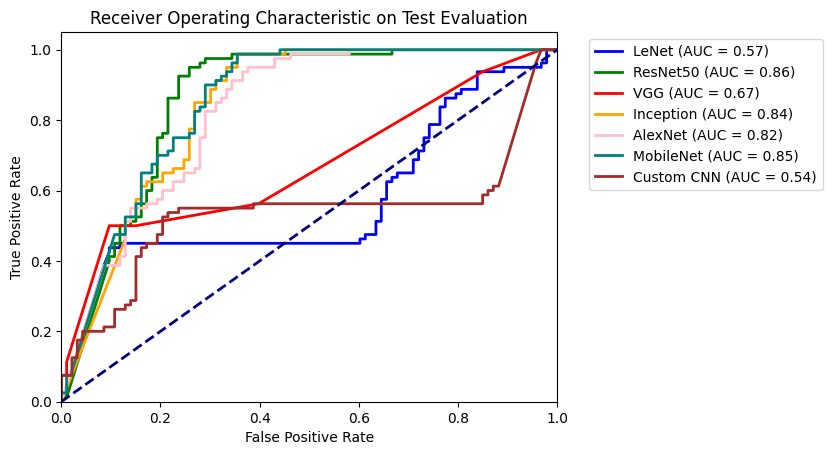

In [57]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

y_true = np.array(y_test)

models = summary_df_cnn['Model Name'].values
colors = ['blue', 'green', 'red', 'orange', 'pink', 'teal', 'brown']  

plt.figure()

for i, model_name in enumerate(models):
    model_probs = summary_df_cnn.loc[summary_df_cnn['Model Name'] == model_name, 'Test Probabilities'].values[0]
    if isinstance(model_probs, str):
        # Convert string representation to actual list
        model_probs = np.fromstring(model_probs.strip("[]"), sep=',')

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, model_probs)
    roc_auc = auc(fpr, tpr)

    # Plotting
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic on Test Evaluation')
# plt.legend(loc="lower right")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Results

In [58]:
# Final Dataframe with results 
results_df = pd.concat([summary_df_traditional,summary_df_nn,summary_df_cnn]).reset_index(drop=True)

In [59]:
results_df.drop(columns=['Validation Probabilities', 'Test Probabilities'])

,Model Name,Validation Accuracy,Validation Precision,Validation Recall,Validation F1 Score,Validation AUC,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test AUC
0,StackingClassifier,0.961749,0.942529,0.976190,0.959064,0.975349,0.945355,0.963855,0.919540,0.941176,0.967074
1,GradientBoostingClassifier,0.956284,0.922222,0.988095,0.954023,0.963684,0.934426,0.941176,0.919540,0.930233,0.946420
2,XGBClassifier,0.967213,0.943182,0.988095,0.965116,0.990741,0.928962,0.962500,0.885057,0.922156,0.982519
3,RandomForestClassifier,0.967213,0.943182,0.988095,0.965116,0.987374,0.950820,0.987500,0.908046,0.946108,0.981741
4,Keras Sequential,0.836066,0.793478,0.869048,0.829545,0.891414,0.792350,0.763441,0.816092,0.788889,0.875359
5,Multi Perceptron,0.956284,0.922222,0.988095,0.954023,0.981481,0.939891,0.931818,0.942529,0.937143,0.966834
6,Autoencoder,0.912568,0.846939,0.988095,0.912088,0.939755,0.868852,0.818182,0.931034,0.870968,0.916667
7,LeNet,0.668605,0.791667,0.447059,0.571429,0.667681,0.682081,0.765957,0.450000,0.566929,0.568481
8,ResNet50,0.674419,0.795918,0.458824,0.582090,0.791210,0.676301,0.785714,0.412500,0.540984,0.858199
9,VGG,0.686047,0.803922,0.482353,0.602941,0.657809,0.699422,0.769231,0.500000,0.606061,0.670968


In [60]:
results_df['Model Name'].values

array(['StackingClassifier', 'GradientBoostingClassifier',
       'XGBClassifier', 'RandomForestClassifier', 'Keras Sequential',
       'Multi Perceptron', 'Autoencoder', 'LeNet', 'ResNet50', 'VGG',
       'Inception', 'AlexNet', 'MobileNet', 'Custom CNN'], dtype=object)

In [61]:
end_time = time.time()
execution_time = end_time - start_time

print("Execution time for the model iteration: {:.2f} seconds".format(execution_time))

Execution time for the model iteration: 131.45 seconds


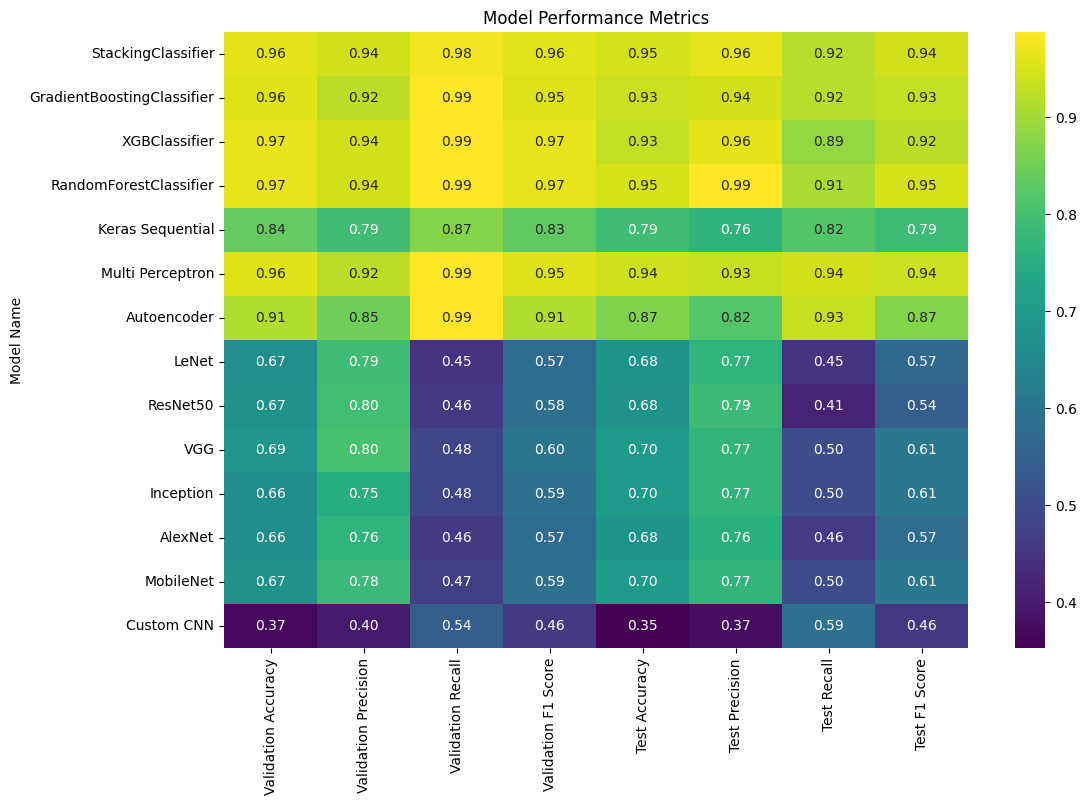

In [62]:
plt.figure(figsize=(12, 8))
sns.heatmap(results_df.drop(columns=['Validation Probabilities', 'Test Probabilities']).set_index('Model Name').drop(['Test AUC', 'Validation AUC'], axis=1),
            annot=True, cmap='viridis', fmt=".2f")
plt.title('Model Performance Metrics')
plt.show()

In [63]:
auc_scores = results_df.set_index('Model Name')['Test AUC'].to_dict()

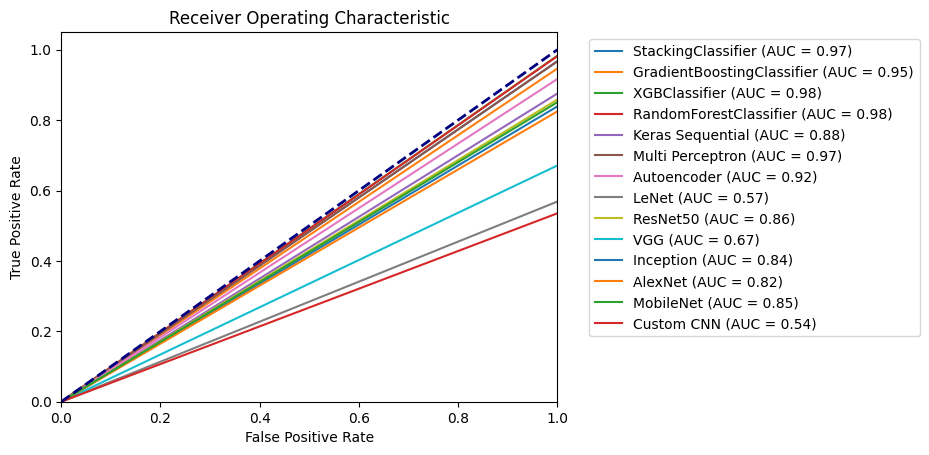

In [64]:

for model_name, auc_score in auc_scores.items():
    fpr = [0, 1]
    tpr = [0, auc_score] 
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
plt.show()

In [65]:
summary_df_traditional

,Model Name,Validation Accuracy,Validation Precision,Validation Recall,Validation F1 Score,Validation AUC,Validation Probabilities,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test AUC,Test Probabilities
0,StackingClassifier,0.961749,0.942529,0.976190,0.959064,0.975349,"[0.04450410781714732, 0.031151746449597752, 0....",0.945355,0.963855,0.919540,0.941176,0.967074,"[0.035184613163516724, 0.02868552657777399, 0...."
1,GradientBoostingClassifier,0.956284,0.922222,0.988095,0.954023,0.963684,"[0.018740280760850915, 0.01830567396225306, 0....",0.934426,0.941176,0.919540,0.930233,0.946420,"[0.01830567396225306, 0.02788020829274152, 0.9..."
2,XGBClassifier,0.967213,0.943182,0.988095,0.965116,0.990741,"[0.010596287, 0.0017872627, 0.99423933, 0.0163...",0.928962,0.962500,0.885057,0.922156,0.982519,"[0.0024642786, 0.0009824767, 0.99076384, 0.533..."
3,RandomForestClassifier,0.967213,0.943182,0.988095,0.965116,0.987374,"[0.05, 0.0, 0.99, 0.03, 0.0, 1.0, 0.06, 0.0, 0...",0.950820,0.987500,0.908046,0.946108,0.981741,"[0.0, 0.0, 0.99, 0.5, 0.95, 0.03, 0.05, 0.08, ..."
